In [1]:
import os
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib as mpl
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
%matplotlib inline
mpl.rcParams.update({'font.size':10})
plasma_map = plt.cm.plasma(np.linspace(0,1,15))
kcolors = {
    'movement': plasma_map[12,:],
    'early': plasma_map[10,:],
    'late': plasma_map[8,:],
    'biphasic': plasma_map[5,:],
    'negative': plasma_map[2,:],
    'unresponsive': 'dimgrey'
}
tcolors = {
    'gaze': 'firebrick',
    'comp': 'mediumblue',
    'rc': 'indigo'
}

In [3]:
psth_bins = np.arange(-200,401)

In [4]:
savepath = '/Users/dmartins/Desktop/Marmoset_071822_panels/'
data = loadmat('/Users/dmartins/Desktop/Marmoset_071822/Pooled_V1Hart_Preload_Final.mat')
totdata = loadmat('/Users/dmartins/Desktop/Marmoset_071822/Pooled_V1Hart_Preload_TotalInfo.mat')

%ISACMOD = [];  % saccade modulation psths for images (each row a neuron)
                % time steps are 1ms, with 50 being saccade offset
%GSACMOD = [];  % saccade modulation psths for gratings (each row a neuron)
%SFTUNE = [];   % spatial freq tuning curves (each row a neuron)
%TFTUNE = [];   % temporal freq tuning (fft of temporal kernel), each row a neuron
%ORTUNE = [];   % orientation tuning per neuron
%BASEMU = [];   % baseline firing rate, to natural images (inclusion criteria?)
%PEAKIM = [];   % time of the peak latency of nat image modulation
%SFGRID = [];   % for each neuron, the spatial frequencies uses in RF 
%ANIMID = [];   % which of the two animals, 1=Allen, 2=Logan

# Rasters for example units

In [13]:
totunits = totdata['TotalInfo']

In [223]:
def mRaster(ax, rast, n=500):
    usetrials = np.array(sorted(np.random.choice(np.arange(0,int(np.max(rast[:,1]))), n, replace=False)))
    
    for row, tnum in enumerate(usetrials):
        sps = rast.copy()
        sps = sps[sps[:,1].astype(int)==tnum]
        sps = sps[:,0]
        
        ax.plot(sps, np.ones(sps.size)*row, '|', color='k', markersize=0.3)
        
    ax.set_xlim([-0.2,0.4])
    ax.set_ylim([n, 0])
    ax.set_yticks(np.linspace(0,n,3))
    
    ax.set_xticks(np.linspace(-.2,.4,4))
    ax.set_xticklabels([])
    # ax.set_xticklabels(np.linspace(-200,400,4).astype(int))
    
    return useinds

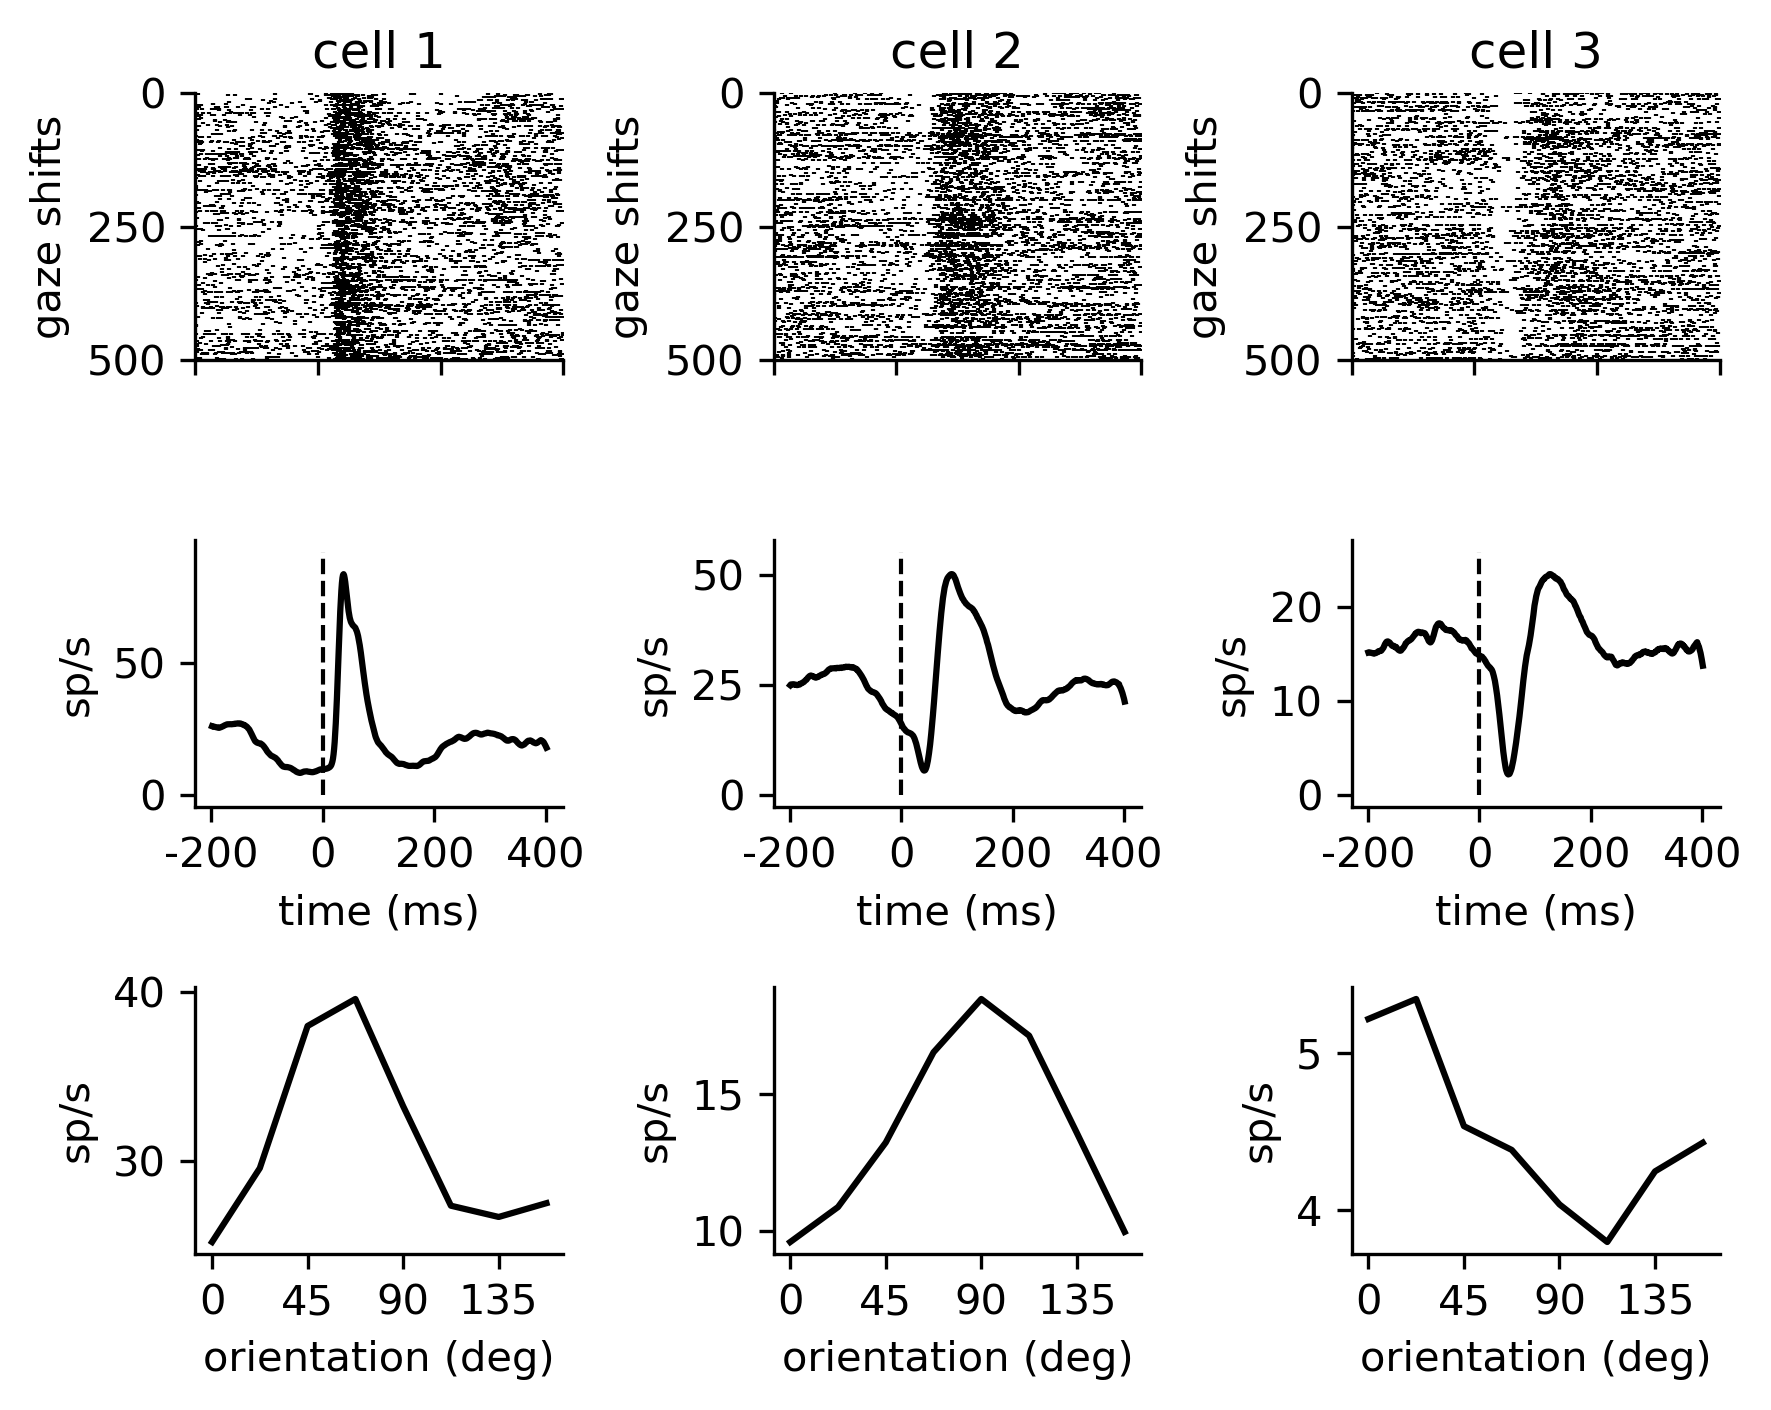

In [268]:
example_units = [9, 96, 30]
# [39, 21, 95] [9, 30]
# 9 is super strong early cell

fig, axs = plt.subplots(3,3, figsize=(6,4.8), dpi=300)

for uPos, uNum in enumerate(example_units):

    unitlabels = ['tagname','pathname','pathplot','isolation','depth','duration',
                  'waveform','channel','shank','ISI','Hart','SacGrating','SacImage']
    unit_dict = dict(zip(unitlabels, list(totunits[uNum][0][0][0])))

    sacimlabels = ['EventList','StimWin','TrialType','StimRast','OriInd','StimTT',
                   'StimUU','StimSU','OriInd2','StimRast2','StimTT2','StimUU2',
                   'StimSU2','BaseMu','BaseMu2']
    sacim_dict = dict(zip(sacimlabels, list(unit_dict['SacImage'][0][0])))


    hartlabels = ['SFcurve','stcounts','stsem','NOri','NSpf','SpatOris','SpatFrqs',
                  'tXX','tempker','sgcounts','sgsem','Ori','OI','SFI','SpatFreq',
                  'ymean','uu','su','otune','sotune','stune','sstune','MyTick','MyTickLabel',
                  'mcounts','msem','pcounts','psem','tcrit','trepa','trepb','FileTag']
    hart_dict = dict(zip(hartlabels, list(unit_dict['Hart'][0][0])))

    useinds = mRaster(axs[0,uPos], sacim_dict['StimRast2'], 500)
    axs[0,uPos].set_ylabel('gaze shifts')
    
    axs[0,uPos].set_title('cell {}'.format(uPos+1))

    axs[1,uPos].plot(sacim_dict['StimTT'].flatten(), sacim_dict['StimUU'].flatten(), 'k-')
    axs[1,uPos].vlines(0,0,np.max(sacim_dict['StimUU'].flatten())*1.1, 'k', linestyle='dashed',linewidth=1)
    axs[1,uPos].set_ylabel('sp/s')
    axs[1,uPos].set_xticks(np.linspace(-.2,.4,4))
    axs[1,uPos].set_xticklabels(np.linspace(-200,400,4).astype(int))
    axs[1,uPos].set_xlabel('time (ms)')

    axs[2,uPos].plot(hart_dict['SpatOris'].flatten(),
                  np.array(hart_dict['otune'].flatten())[:int(np.size(hart_dict['SpatOris'].flatten()))],
                  color='k')
    axs[2,uPos].set_xticks(hart_dict['SpatOris'].flatten()[::2].astype(int))
    axs[2,uPos].set_xlabel('orientation (deg)')
    axs[2,uPos].set_ylabel('sp/s')

fig.tight_layout()

fig.savefig(os.path.join(savepath, '6_example_cells.pdf'))

# Cross validation

In [ ]:
def normalize_psth(psth, raw_pref=None, baseline_val=None):
    if raw_pref is None:
        raw_pref = psth.copy()
    if baseline_val is None:
        baseline_val = np.nanmean(psth[0:800].astype(float))
    norm_psth = (psth - baseline_val) / np.nanmax(raw_pref[750:1250].astype(float))
    return norm_psth

norm_train = np.zeros([len(good_inds),2001])
norm_test = np.zeros([len(good_inds),2001])
for i, ind in enumerate(good_inds):
    norm_train[i,:] = normalize_psth(train_psth[ind,:])
    norm_test[i,:] = normalize_psth(test_psth[ind,:])

# Open in arrays

In [5]:
sacc_psth = data['ISACMOD']
grat_psth = data['GSACMOD']
sf_tuning = data['SFTUNE']
tf_tuning = data['TFTUNE']
ori_tuning = data['ORTUNE']
bsln_fr = data['BASEMU']
peakT = data['PEAKIM']
animal = data['ANIMID']

In [8]:
n_cells = np.size(peakT,0)

def normalize_psth(psth):
    pref = psth.copy()
    bsln = np.mean(psth[100:150]) # -100 to -50
    norm_psth = (psth - bsln) / np.max(pref[200:]) # 0 to 200
    return norm_psth

norm_sacc_psth = np.zeros([n_cells, len(psth_bins)])
for ind in range(n_cells):
    norm_sacc_psth[ind,:] = normalize_psth(sacc_psth[ind].copy())

Text(0.5, 1.0, 'new norm')

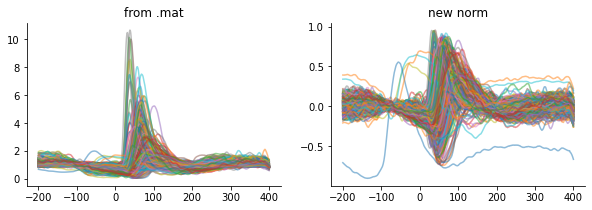

In [9]:
fig, [ax0, ax1] = plt.subplots(1,2,figsize=(10,3))
for ind in range(n_cells):
    ax0.plot(psth_bins, sacc_psth[ind,:], alpha=0.5)
    ax1.plot(psth_bins, norm_sacc_psth[ind,:], alpha=0.5)
ax0.set_title('from .mat')
ax1.set_title('new norm')

# Grat prefs

In [10]:
# spatial and temporal frequencies used
sf_vals = np.array([1,2,4,8,16])
tf_vals = (60/16) * np.arange(9)

tf_pref = np.zeros(n_cells); sf_pref = np.zeros(n_cells)
ori_index = np.zeros(n_cells); tf_index = np.zeros(n_cells); sf_index = np.zeros(n_cells);


for ind in range(n_cells):
    sf = sf_tuning[ind,:].copy()
    tf = tf_tuning[ind,:].copy()
    ori = ori_tuning[ind,:].copy()
    
    ofi = np.nanstd(ori) / np.nanmean(ori)
    sfi = np.nanstd(sf) / np.nanmean(sf)
    tfi = np.nanstd(tf) / np.nanmean(tf)
    
    svec = sf.copy()-1
    svec[svec<0] = 0
    svec = svec**2
    spref = np.nansum(svec * sf_vals) / np.nansum(svec)
    
    tvec = tf.copy()-1
    tvec[tvec<0] = 0
    tvec = tvec**2
    tpref = np.nansum(tvec * tf_vals) / np.nansum(tvec)
    
    sf_pref[ind] = spref
    tf_pref[ind] = tpref
    ori_index[ind] = ofi
    sf_index[ind] = sfi
    tf_index[ind] = tfi

/var/folders/m6/hd0m9df55nz7_qzkbk4vpcwc0000gn/T/ipykernel_64161/364095090.py:21: RuntimeWarning: invalid value encountered in double_scalars
  spref = np.nansum(svec * sf_vals) / np.nansum(svec)


In [ ]:
tf_vals

array([ 0.  ,  3.75,  7.5 , 11.25, 15.  , 18.75, 22.5 , 26.25, 30.  ])

In [ ]:
sf_vals

array([ 1,  2,  4,  8, 16])

In [11]:
def psth_modind(psth):
    # modulation in terms of spike rate
    psth = psth.astype(float)
    use = psth - np.mean(psth[0:150].copy())
    mod = np.max(np.abs(use[200:]))
    return mod

sacc_resp = np.zeros(n_cells)
mods = np.zeros(n_cells)
for ind in range(n_cells):
    mod = psth_modind(norm_sacc_psth[ind,:])
    mods[ind] = mod
    if mod > 0.1:
        sacc_resp[ind] = True

In [12]:
pca_input = norm_sacc_psth.copy()

n_pcas = 10
pca = PCA(n_components=n_pcas)
pca.fit(pca_input)

explvar = pca.explained_variance_ratio_

proj = pca.transform(pca_input)

keep_pcas = int(np.argwhere(np.cumsum(explvar)>.95)[0])
print('using best {} PCs'.format(keep_pcas))

gproj = proj[:,:keep_pcas]

km = KMeans(n_clusters=4) ### using 4 clusters, not 5...
km.fit_predict(gproj)
Z = km.labels_

using best 6 PCs


In [17]:
kord = [2,3,0,1]

color_list = [kcolors['early'],
          kcolors['late'],
          kcolors['biphasic'],
          kcolors['negative']
         ]

In [18]:
clusters = Z.copy()

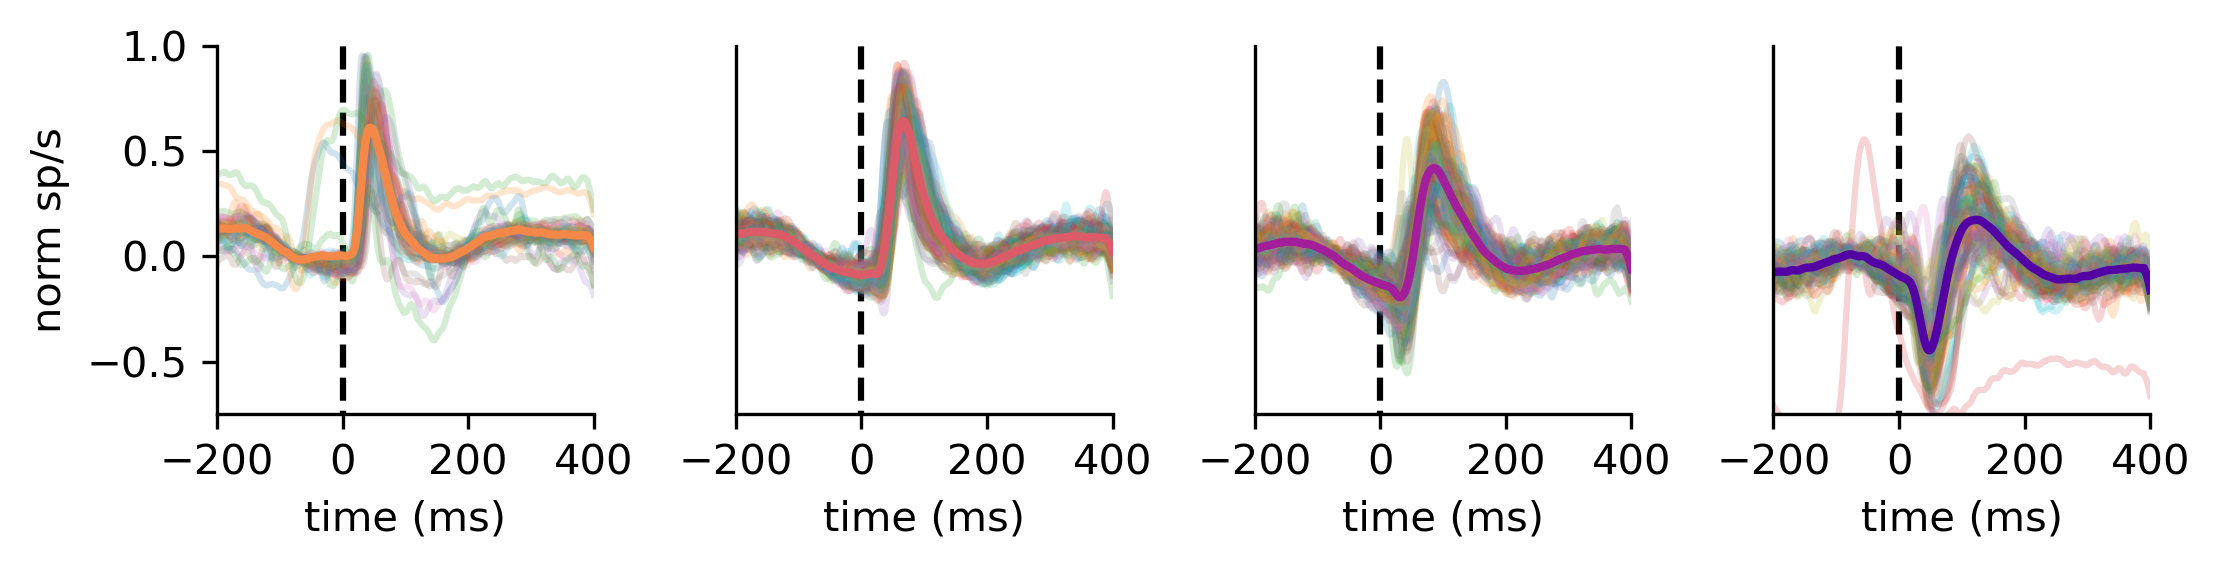

In [20]:
fig, axs = plt.subplots(1,4,figsize=(7.5,2), dpi=300)
for ki, k in enumerate(kord):
    ax = axs[ki]
    inds = np.argwhere(clusters==k).flatten()
    for ind in inds:
        psth = norm_sacc_psth[ind,:]
        ax.plot(psth_bins, psth, alpha=0.2)
    ax.plot(psth_bins, np.nanmean(norm_sacc_psth[inds,:], axis=0), color=color_list[ki], linewidth=2)
    ax.set_ylim([-0.75,1])
    ax.vlines(0, -1, 1, color='k', linestyle='dashed')
    ax.set_xticks(np.linspace(-200,400,4))
    ax.set_xlim([-200,400])
    ax.set_xlabel('time (ms)')
    if ki>0:
        ax.set_yticks([])
    if ki==0:
        ax.set_ylabel('norm sp/s')
fig.tight_layout()
fig.savefig(os.path.join(savepath, '6_clusters.pdf'))

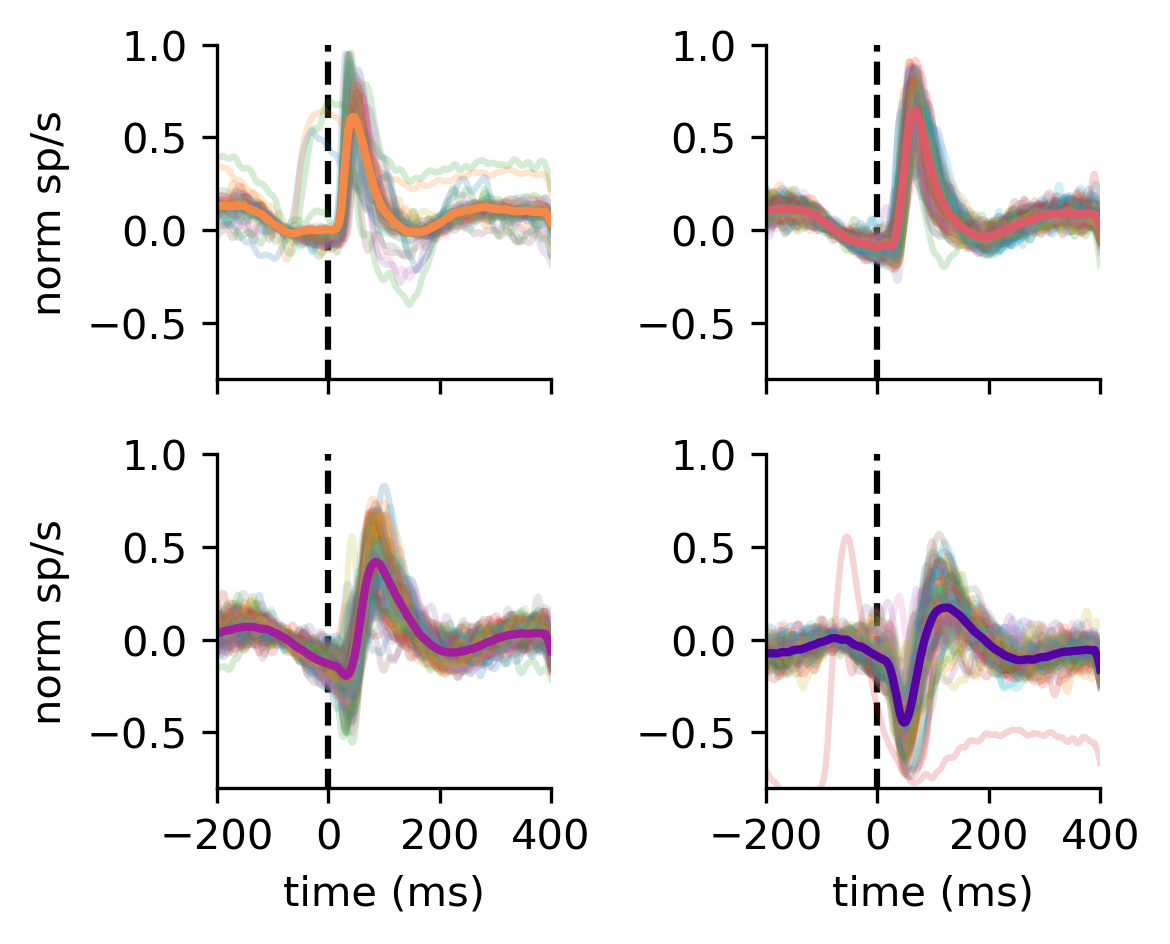

In [86]:
fig, axs = plt.subplots(2,2,figsize=(4,3.25), dpi=300)
for ki, k in enumerate(kord):
    ax = axs.flatten()[ki]
    inds = np.argwhere(clusters==k).flatten()
    for ind in inds:
        psth = norm_sacc_psth[ind,:]
        ax.plot(psth_bins, psth, alpha=0.2)
    ax.plot(psth_bins, np.nanmean(norm_sacc_psth[inds,:], axis=0), color=color_list[ki], linewidth=2)
    ax.set_ylim([-0.8,1])
    ax.vlines(0, -1, 1, color='k', linestyle='dashed')
    ax.set_xticks(np.linspace(-200,400,4))
    ax.set_xlim([-200,400])
    if ki<2:
        ax.set_xticklabels([])
    if ki==0 or ki==2:
        ax.set_ylabel('norm sp/s')
    if ki>1:
        ax.set_xlabel('time (ms)')
fig.tight_layout()
fig.savefig(os.path.join(savepath, '6_clusters_sq.pdf'))

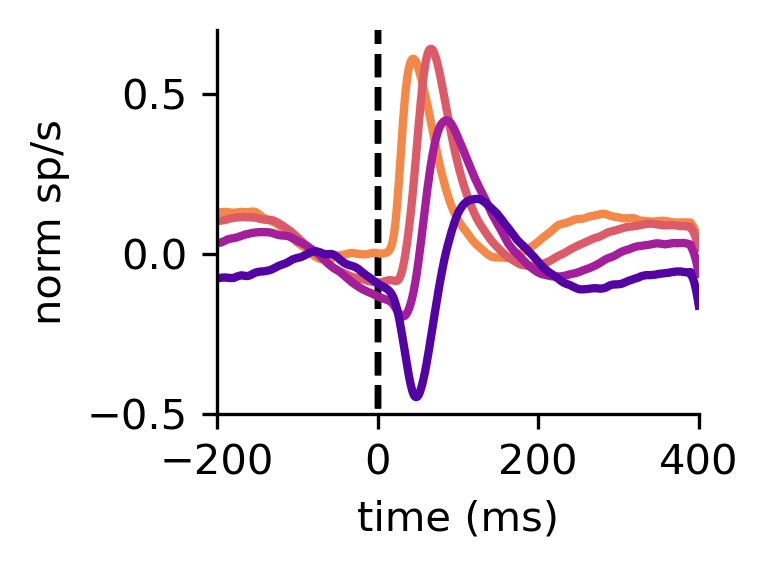

In [22]:
fig, ax = plt.subplots(1,1,figsize=(2.75,2), dpi=300)
for ki, k in enumerate(kord):
    inds = np.argwhere(clusters==k).flatten()
    for ind in inds:
        psth = norm_sacc_psth[ind,:]
        # ax.plot(psth_bins, psth, alpha=0.2)
    ax.plot(psth_bins, np.nanmean(norm_sacc_psth[inds,:], axis=0), color=color_list[ki], linewidth=2)
    ax.set_ylim([-.5,.7])
    ax.vlines(0, -1, 1, color='k', linestyle='dashed')
    
ax.set_xlim([-200,400])
ax.set_xticks(np.linspace(-200,400,4))
ax.set_xlabel('time (ms)')
ax.set_ylabel('norm sp/s')

fig.tight_layout()
fig.savefig(os.path.join(savepath, '6_all_clusters.pdf'))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

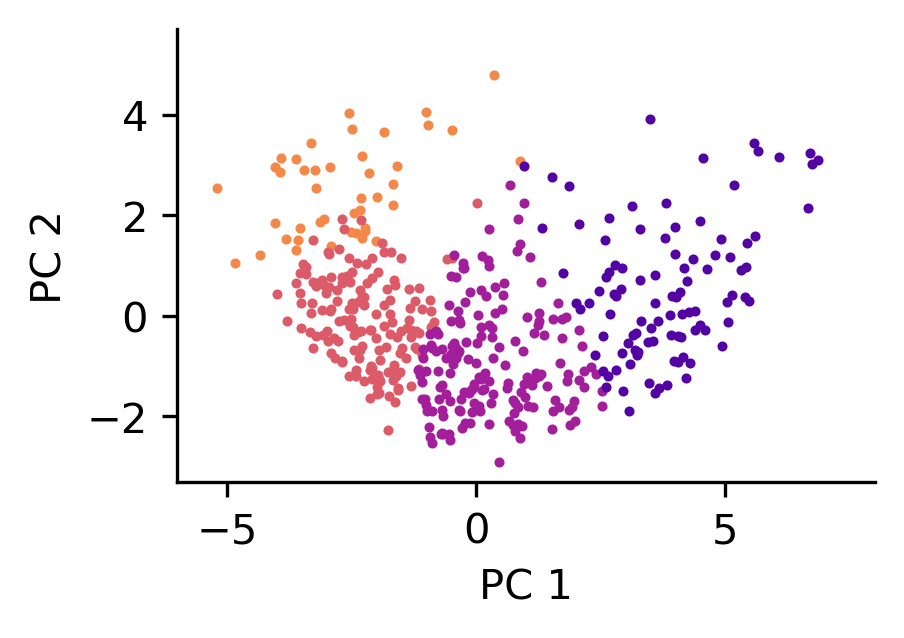

In [24]:
fig, ax = plt.subplots(1,1,figsize=(3,2), dpi=300)
for ki, k in enumerate(kord):
    inds = np.argwhere(clusters==k).flatten()
    ax.scatter(proj[inds,0], proj[inds,1], s=2, c=color_list[ki])
ax.set_xlabel('PC 1'); ax.set_ylabel('PC 2')

# ax.set_ylim([-4,6])
ax.set_xlim([-6,8])

fig.savefig(os.path.join(savepath, '6_pca.pdf'))

In [25]:
def plot_cprop_scatter(ax, data, clusters, color_list):
    for ki, k in enumerate(kord):
        
        inds = np.argwhere(clusters==k).flatten()
        kdata = data[inds].copy()
        
        x_jitter = np.random.uniform(ki-0.2, ki+0.2, np.size(kdata,0))
        
        ax.plot(x_jitter, kdata, '.', color=color_list[ki], markersize=2)
        
        hline = np.nanmedian(kdata)
        err = np.std(kdata) / np.sqrt(np.size(kdata))
        
        ax.hlines(hline, ki-0.2, ki+0.2, color='k', linewidth=2)
        ax.vlines(ki, hline-err, hline+err, color='k', linewidth=2)
        
        ax.set_xticks(range(4))
        ax.set_xticklabels(['early','late','biphasic','negative'])

In [26]:
from scipy import stats
def running_median(ax, x, y, n_bins=7):
    bins = np.linspace(np.min(x), np.max(x), n_bins)
    bin_means, bin_edges, bin_number = stats.binned_statistic(x[~np.isnan(x) & ~np.isnan(y)], y[~np.isnan(x) & ~np.isnan(y)], statistic=np.median, bins=bins)
    bin_std, _, _ = stats.binned_statistic(x[~np.isnan(x) & ~np.isnan(y)], y[~np.isnan(x) & ~np.isnan(y)], statistic=np.nanstd, bins=bins)
    hist, _ = np.histogram(x[~np.isnan(x) & ~np.isnan(y)], bins=bins)
    tuning_err = bin_std / np.sqrt(hist)
    ax.plot(bin_edges[:-1] + (np.median(np.diff(bins))/2), bin_means, '-', color='k')
    ax.fill_between(bin_edges[:-1] + (np.median(np.diff(bins))/2), bin_means-tuning_err, bin_means+tuning_err, color='k', alpha=0.2)

In [27]:
grat_resp = np.zeros(n_cells)
for ind in range(n_cells):
    ffi = np.sqrt(ori_index[ind]**2 + sf_index[ind]**2)
    if ffi >= 0.2:
        grat_resp[ind] = True
grat_resp = grat_resp.astype(bool)

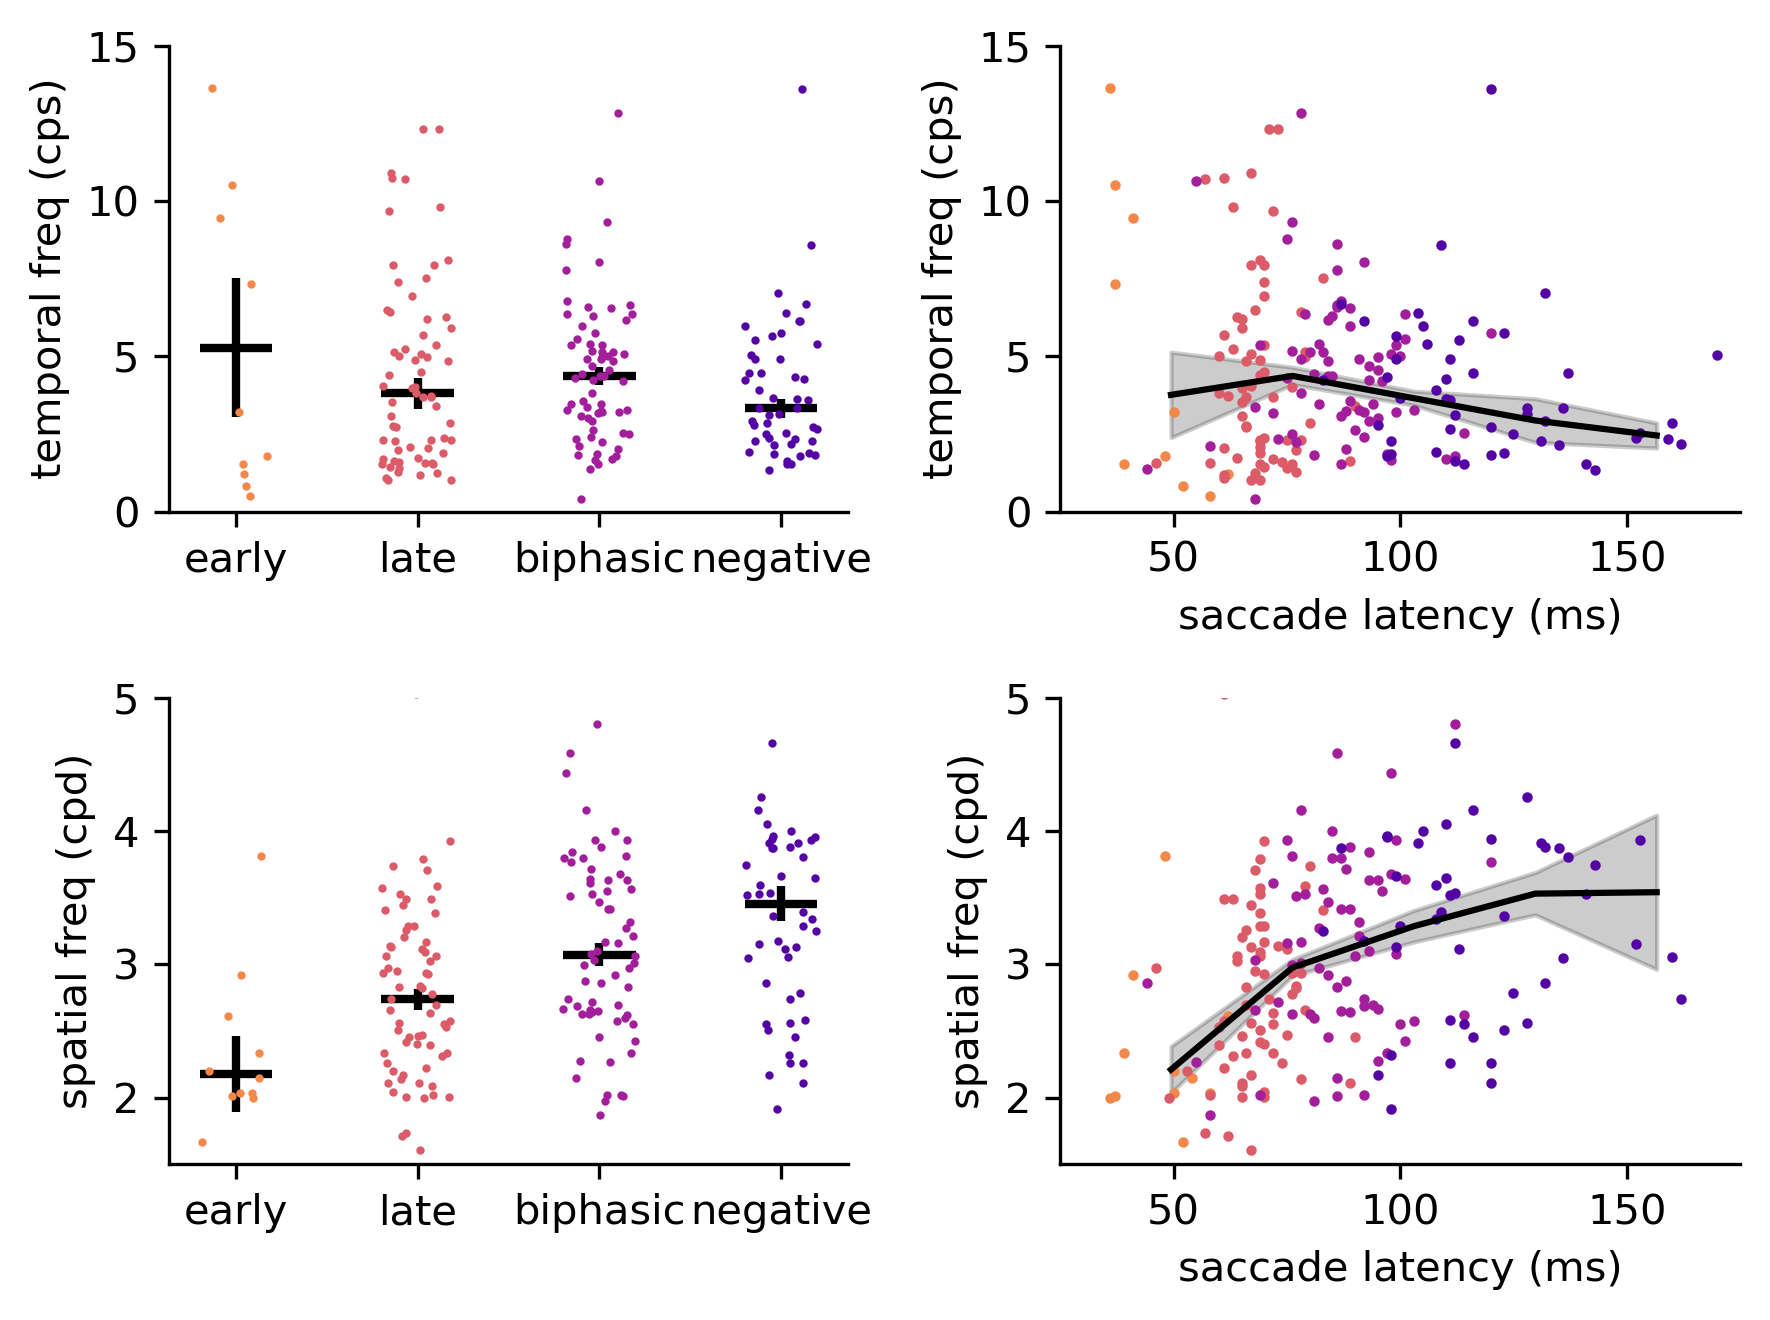

In [122]:
fig, [[ax0,ax1],[ax2,ax3]] = plt.subplots(2,2, figsize=(6,4.5), dpi=300)

# use = np.argwhere((grat_resp)).flatten()
use = np.argwhere((grat_resp) * (peakT.flatten()>25) * (peakT.flatten()<175)).flatten()

plot_cprop_scatter(ax0, tf_pref[use], clusters[use], color_list)
ax0.set_ylabel('temporal freq (cps)')

plot_cprop_scatter(ax2, sf_pref[use], clusters[use], color_list)
ax2.set_ylabel('spatial freq (cpd)')

for ki, k in enumerate(kord):
    inds = np.intersect1d(np.argwhere((clusters==k)).flatten(), use)
    
    ax1.plot(peakT.flatten()[inds], tf_pref[inds], '.', color=color_list[ki], markersize=3)
    ax3.plot(peakT.flatten()[inds], sf_pref[inds], '.', color=color_list[ki], markersize=3)
    
running_median(ax1, peakT.flatten()[use], tf_pref[use], n_bins=6)
running_median(ax3, peakT.flatten()[use], sf_pref[use], n_bins=6)

ax1.set_xlabel('saccade latency (ms)')
ax3.set_xlabel('saccade latency (ms)')
ax1.set_ylabel('temporal freq (cps)')
ax3.set_ylabel('spatial freq (cpd)')
    
ax1.set_xlim([25,175])
ax3.set_xlim([25,175])
ax0.set_ylim([0, 15]); ax1.set_ylim([0, 15])
ax2.set_ylim([1.5, 5]); ax3.set_ylim([1.5, 5])

fig.tight_layout()

fig.savefig(os.path.join(savepath, '6_sf_tf_scatter_withlim.pdf'))

(array([ 1.,  2.,  0.,  5., 13., 20., 15.,  8.,  2.,  2.]),
 array([ 44. ,  51.6,  59.2,  66.8,  74.4,  82. ,  89.6,  97.2, 104.8,
        112.4, 120. ]),
 <BarContainer object of 10 artists>)

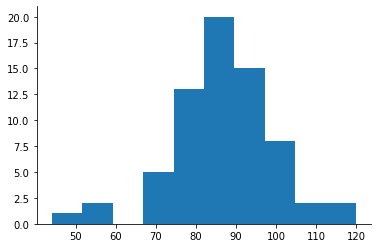

In [113]:
use = np.argwhere((grat_resp) * (peakT.flatten()>25) * (peakT.flatten()<150)).flatten()
inds = np.intersect1d(np.argwhere((clusters==0)).flatten(), use)
plt.hist(peakT.flatten()[inds])

In [104]:
from scipy.stats import linregress

In [124]:
x = peakT.flatten()[use]
y = tf_pref[use]

res = linregress(x, y)
(res.rvalue)**2

0.05988008126106221

In [92]:
len(peakT.flatten()[grat_resp])

206

In [98]:
use = np.argwhere((grat_resp) * (peakT.flatten()>25) * (peakT.flatten()<150)).flatten()
np.unique(clusters[use], return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([68, 44, 12, 69]))

In [102]:
len(use)

205

In [34]:
latency_sort = np.argsort(peakT.flatten().copy())
tempseq = norm_sacc_psth.copy()[latency_sort]

In [51]:
def plot_tempseq(ax, seq):
    
    ax.set_xlabel('time (msec)')
    ax.set_ylim([np.size(seq,0),0])
    
    vmin = -0.75; vmax = 0.75
    img = ax.imshow(seq, cmap='coolwarm', vmin=vmin, vmax=vmax)
    
    ax.set_xlim([0,601])
    
    ax.set_xticks(np.linspace(0,600,4))
    ax.set_xticklabels(labels=np.linspace(-200,400,4).astype(int))
    ax.vlines(200, 0, np.size(seq,0), color='k', linestyle='dashed', linewidth=1)
    
    ax.set_aspect(2.8)
    
    return img

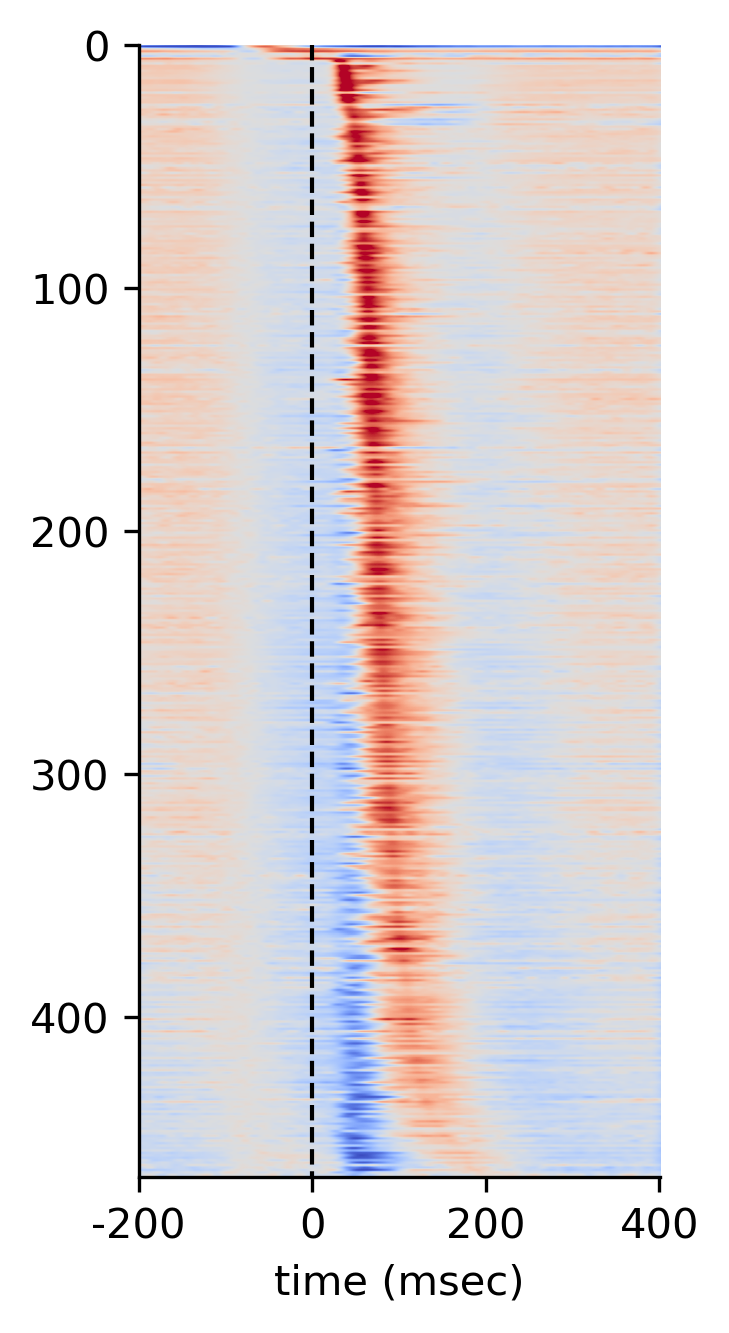

In [52]:
fig, ax = plt.subplots(1,1, dpi=300, figsize=(5,5))
plot_tempseq(ax, tempseq)
fig.savefig(os.path.join(savepath, '6_tempseq.pdf'))

In [53]:
color_list = [kcolors['early'],
          kcolors['late'],
          kcolors['biphasic'],
          kcolors['negative']
         ]

In [54]:
k_to_name = {
    2:'early',
    3:'late',
    0:'biphasic',
    1:'negative'
}

In [55]:
sorted_clusters = clusters.copy()[latency_sort]

tempseq_legend = np.zeros([n_cells, 1, 4])
for ki, k in enumerate(sorted_clusters):
    tempseq_legend[ki,:,:] = kcolors[k_to_name[k]]

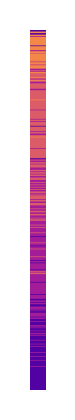

In [56]:
fig, ax = plt.subplots(1,1,figsize=(0.5,1.5), dpi=300)
ax.imshow(tempseq_legend, aspect=.05)
ax.set_yticks([]); ax.set_xticks([])
ax.axes.spines.bottom.set_visible(False)
ax.axes.spines.right.set_visible(False)
ax.axes.spines.left.set_visible(False)
ax.axes.spines.top.set_visible(False)
plt.tight_layout()
fig.savefig(os.path.join(savepath, '6_tempseq_legend.pdf'))

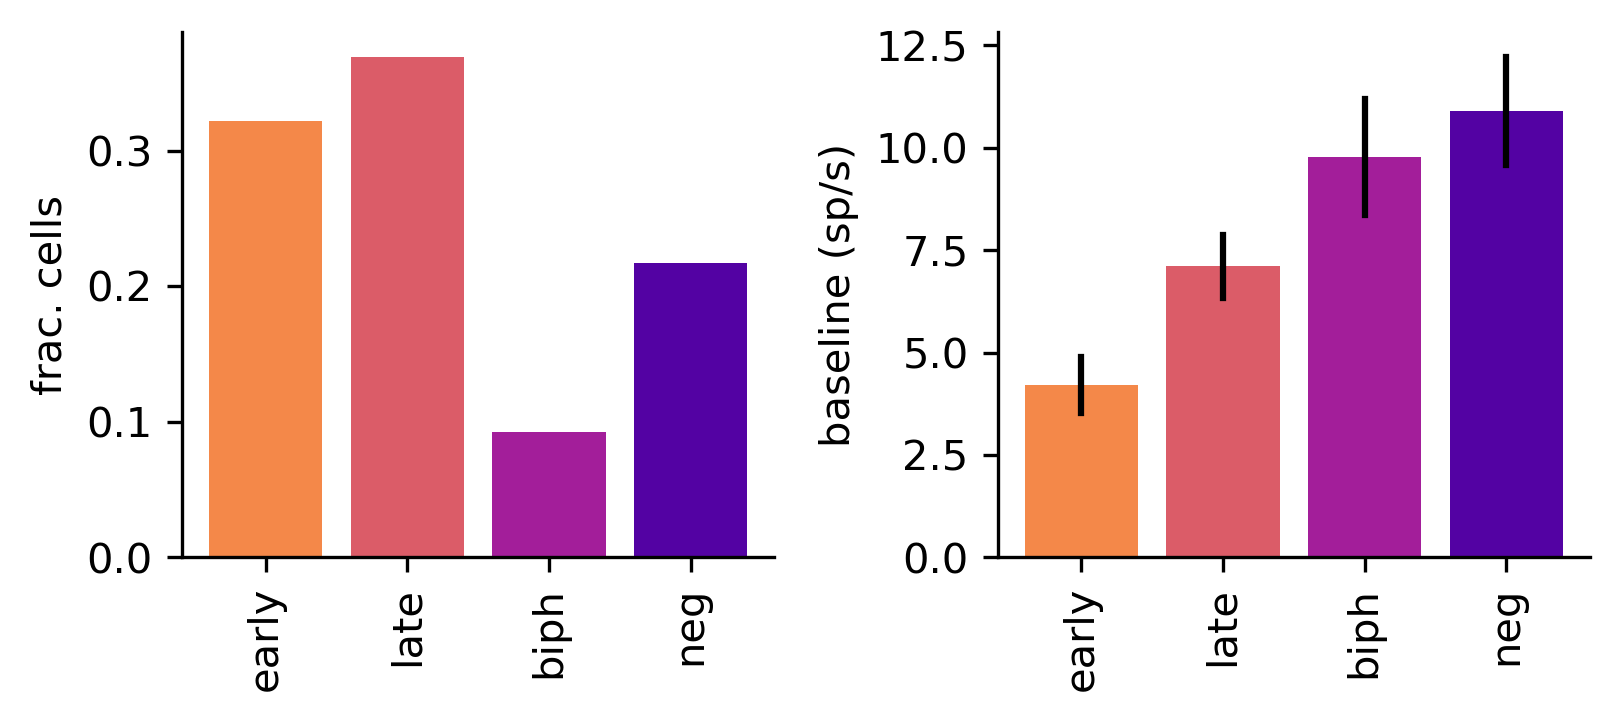

In [57]:
fig, [ax_cellcounts, ax_baseline_fr] = plt.subplots(1,2, figsize=(5.5,2.5), dpi=300)


names = ['early','late','biphasic','negative']
print_names = ['early','late','biph','neg']

for ki, k in enumerate([3, 0, 2, 1]):
    inds = np.argwhere((clusters==k)).flatten()
    ax_cellcounts.bar(ki, len(inds)/n_cells, color=color_list[ki])
    
ax_cellcounts.set_xticks(ticks=range(4))
ax_cellcounts.set_xticklabels(print_names, rotation=90)
ax_cellcounts.set_ylabel('frac. cells')

for ki, k in enumerate([3, 0, 2, 1]):
    inds = np.argwhere((clusters==k)).flatten()
    bsln_plot_vals = bsln_fr[inds]
    
    err = np.nanstd(bsln_plot_vals) / np.sqrt(np.size(bsln_plot_vals))
    med = np.nanmedian(bsln_plot_vals)
    
    ax_baseline_fr.bar(ki, med, color=color_list[ki])
    ax_baseline_fr.plot([ki, ki], [med-err, med+err], 'k-')
    
ax_baseline_fr.set_xticks(range(4))
ax_baseline_fr.set_xticklabels(print_names, rotation=90)
ax_baseline_fr.set_ylabel('baseline (sp/s)')

fig.tight_layout()
fig.savefig(os.path.join(savepath, '6_ksize_bslnFr.pdf'))

In [87]:
n_cells

466

In [90]:
np.unique(clusters, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([172, 101,  43, 150]))

In [91]:
kord

[2, 3, 0, 1]